# Gout Flare Detection: SMOTE vs No SMOTE Comparison

This notebook was developed by **I Made Akira Ivandio Agusta (15406525)**, Coventry University.

This second notebook addresses the gout flare dataset's **class imbalance** by comparing the model's performance with and without applying **SMOTE (Synthetic Minority Oversampling Technique)**.

This evaluation uses the best-performing model of the first notebook: **Support Vector Machine with TF-IDF features**.

## Data Loading and Preprocessing

This section outlines the initial **data loading and preprocessing** steps, similar to the first notebook. The pipeline is data loading, text preprocessing, data splitting into train and test sets, and feature extraction using TF-IDF.

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.sparse import issparse
from sklearn.base import clone
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (average_precision_score, classification_report,
                             confusion_matrix, f1_score, precision_recall_curve,
                             precision_score, recall_score, roc_curve, auc)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.svm import LinearSVC

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
warnings.filterwarnings("ignore")

In [ ]:
# Load the 2019 data
filepath_2019 = 'dataset/GOUT-CC-2019-CORPUS-SYNTHETIC.tsv'
df_2019 = pd.read_csv(filepath_2019, delimiter='\t')

# Load the 2020 data
filepath_2020 = 'dataset/GOUT-CC-2020-CORPUS-SYNTHETIC.tsv'
df_2020 = pd.read_csv(filepath_2020, delimiter='\t')

# Concatenate the dataframes
df = pd.concat([df_2019, df_2020], ignore_index=True)

# Drop the 'Consensus' column
df = df.drop(columns=['Consensus'])

# Drop rows where 'Predict' is '-'
df = df[df['Predict'] != '-']
df

,Chief Complaint,Predict
0,"""been feeling bad"" last 2 weeks & switched BP ...",N
1,"""can't walk"", reports onset at 0830 am. orient...",Y
2,"""dehydration"" Chest hurts, hips hurt, cramps P...",Y
3,"""gout flare up"" L arm swelling x 1 week. denie...",Y
4,"""heart racing,""dyspnea, and orthopnea that has...",N
...,...,...
8432,"stepped on a nail at home with right foot, pai...",N
8433,""" I was having a breakdown."" R/T stress and de...",N
8434,"""I tried to jump in front of a car"" Pt states ...",N
8435,Abdominal pain x 1 week. Denies PMH,N


In [ ]:
# Create class for preprocessing
class TextPreprocessor:
    """
    Class for preprocessing chief complaint text data
    """
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        """
        Basic text cleaning
        """
        # Convert to lowercase
        text = text.lower()

        # Remove special characters but keep important medical symbols
        text = re.sub(r'[^a-z0-9\s+/-]', ' ', text)

        # Standardise spacing
        text = ' '.join(text.split())

        return text

    def process_text(self, text, remove_stopwords=True, lemmatize=True):
        """
        Complete text preprocessing pipeline
        """
        # Clean text
        text = self.clean_text(text)

        # Tokenise
        tokens = word_tokenize(text)

        # Remove stopwords if requested
        if remove_stopwords:
            tokens = [token for token in tokens if token not in self.stop_words]

        # Lemmatise if requested
        if lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        # Join tokens back into text
        processed_text = ' '.join(tokens)

        return processed_text

In [ ]:
# Preprocess the dataset
preprocessor = TextPreprocessor()
df['Processed Text'] = df['Chief Complaint'].apply(preprocessor.process_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['Processed Text'], df['Predict'], test_size=0.2, random_state=42, stratify=df['Predict']
)

# Feature extraction with TF-IDF
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), stop_words='english')
X_tfidf = tfidf.fit_transform(df['Processed Text'])
y = df['Predict'].values

## SMOTE vs No SMOTE

This section outlines the result of **applying vs not applying SMOTE** in model training. For both scenarios, the model is trained with **SVM using TF-IDF features**.

The evaluation and analysis include: **class-specific metrics, confusion matrices, F1-score comparisons by class,** and **ROC curves.**

In [ ]:
# Define readable class labels
class_labels = {0: "No (N)", 1: "Unknown (U)", 2: "Yes (Y)"}

# Create class for model training with cross-validation evaluation
def cv_with_class_metrics(X, y, model, model_name, use_smote=False):
    # Initialise stratified k-fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Convert string labels to numeric for easier handling
    label_map = {'N': 0, 'U': 1, 'Y': 2}
    y_numeric = np.array([label_map[label] for label in y])

    # Metrics storage
    class_metrics = {c: {'precision': [], 'recall': [], 'f1': []} for c in range(3)}
    weighted_f1_scores = []

    # Store all predictions and true values across folds
    all_true = []
    all_pred = []

    # ROC and PR curve data
    roc_data = {c: {'fpr': [], 'tpr': [], 'auc': []} for c in range(3)}
    pr_data = {c: {'precision': [], 'recall': [], 'ap': []} for c in range(3)}

    # For each fold
    for train_idx, test_idx in skf.split(X, y_numeric):
        # Split data
        if issparse(X):
            X_train, X_test = X[train_idx], X[test_idx]
        else:
            X_train, X_test = X[train_idx, :], X[test_idx, :]
        y_train, y_test = y_numeric[train_idx], y_numeric[test_idx]

        # Apply SMOTE if requested
        if use_smote:
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)

        # Train model
        clf = clone(model)
        clf.fit(X_train, y_train)

        # Predict
        y_pred = clf.predict(X_test)

        # Store predictions and true values
        all_true.extend(y_test)
        all_pred.extend(y_pred)

        # Calculate weighted F1
        weighted_f1 = f1_score(y_test, y_pred, average='weighted')
        weighted_f1_scores.append(weighted_f1)

        # Calculate per-class metrics
        for c in range(3):
            # Binary metrics
            y_true_c = (y_test == c)
            y_pred_c = (y_pred == c)

            # Precision, recall, F1
            precision = precision_score(y_true_c, y_pred_c)
            recall = recall_score(y_true_c, y_pred_c)
            f1 = f1_score(y_true_c, y_pred_c)

            class_metrics[c]['precision'].append(precision)
            class_metrics[c]['recall'].append(recall)
            class_metrics[c]['f1'].append(f1)

            # ROC curve data if model supports decision_function
            try:
                if hasattr(clf, 'decision_function'):
                    # Get decision scores
                    if clf.decision_function(X_test).ndim > 1:
                        # Multi-class
                        decision_scores = clf.decision_function(X_test)[:, c]
                    else:
                        # Binary
                        decision_scores = clf.decision_function(X_test)

                    # ROC curve
                    fpr, tpr, _ = roc_curve(y_true_c, decision_scores)
                    roc_auc = auc(fpr, tpr)

                    roc_data[c]['fpr'].append(fpr)
                    roc_data[c]['tpr'].append(tpr)
                    roc_data[c]['auc'].append(roc_auc)

                    # PR curve
                    precision_curve, recall_curve, _ = precision_recall_curve(y_true_c, decision_scores)
                    avg_precision = average_precision_score(y_true_c, decision_scores)

                    pr_data[c]['precision'].append(precision_curve)
                    pr_data[c]['recall'].append(recall_curve)
                    pr_data[c]['ap'].append(avg_precision)
            except:
                # Skip if decision_function doesn't work
                pass

    # Create a single confusion matrix from all predictions
    overall_cm = confusion_matrix(all_true, all_pred)

    # Calculate mean metrics
    mean_metrics = {}
    for c in range(3):
        mean_metrics[c] = {
            'precision': np.mean(class_metrics[c]['precision']),
            'recall': np.mean(class_metrics[c]['recall']),
            'f1': np.mean(class_metrics[c]['f1']),
            'auc': np.mean(roc_data[c]['auc']) if roc_data[c]['auc'] else None
        }

    # Display results
    print(f"\n--- {model_name} Results ---")
    print(f"Mean CV Weighted F1: {np.mean(weighted_f1_scores):.5f}")

    # Display class-specific metrics table
    print("\nClass-specific metrics:")
    metrics_df = pd.DataFrame([
        {
            'Class': class_labels[c],
            'Precision': f"{mean_metrics[c]['precision']:.5f}",
            'Recall': f"{mean_metrics[c]['recall']:.5f}",
            'F1 Score': f"{mean_metrics[c]['f1']:.5f}",
            'ROC AUC': f"{mean_metrics[c]['auc']:.5f}" if mean_metrics[c]['auc'] else "N/A"
        }
        for c in range(3)
    ])
    print(metrics_df)

    return overall_cm, np.mean(weighted_f1_scores), mean_metrics, roc_data

In [ ]:
# Initialise SVM Model
svm_model = LinearSVC(random_state=42)

# Evaluate SVM without SMOTE
cm_no_smote, f1_no_smote, metrics_no_smote, roc_data_no_smote = cv_with_class_metrics(X_tfidf, y, svm_model, "SVM without SMOTE")

# Evaluate SVM with SMOTE
cm_smote, f1_smote, metrics_smote, roc_data_smote = cv_with_class_metrics(X_tfidf, y, svm_model, "SVM with SMOTE", use_smote=True)

# Compare results
print("\n--- Comparison Results (Cross-Validation) ---")
print(f"Mean CV F1 Score without SMOTE: {f1_no_smote:.5f}")
print(f"Mean CV F1 Score with SMOTE: {f1_smote:.5f}")
print(f"Difference: {f1_smote - f1_no_smote:.5f}")


--- SVM without SMOTE Results ---
Mean CV Weighted F1: 0.96942

Class-specific metrics:
         Class Precision   Recall F1 Score  ROC AUC
0       No (N)   0.98087  0.99804  0.98938  0.96881
1  Unknown (U)   0.36000  0.09657  0.15055  0.89211
2      Yes (Y)   0.76853  0.57470  0.65112  0.99516

--- SVM with SMOTE Results ---
Mean CV Weighted F1: 0.96623

Class-specific metrics:
         Class Precision   Recall F1 Score  ROC AUC
0       No (N)   0.98804  0.97980  0.98389  0.96359
1  Unknown (U)   0.24117  0.34052  0.27891  0.83187
2      Yes (Y)   0.62726  0.64704  0.63219  0.99149

--- Comparison Results (Cross-Validation) ---
Mean CV F1 Score without SMOTE: 0.96942
Mean CV F1 Score with SMOTE: 0.96623
Difference: -0.00319


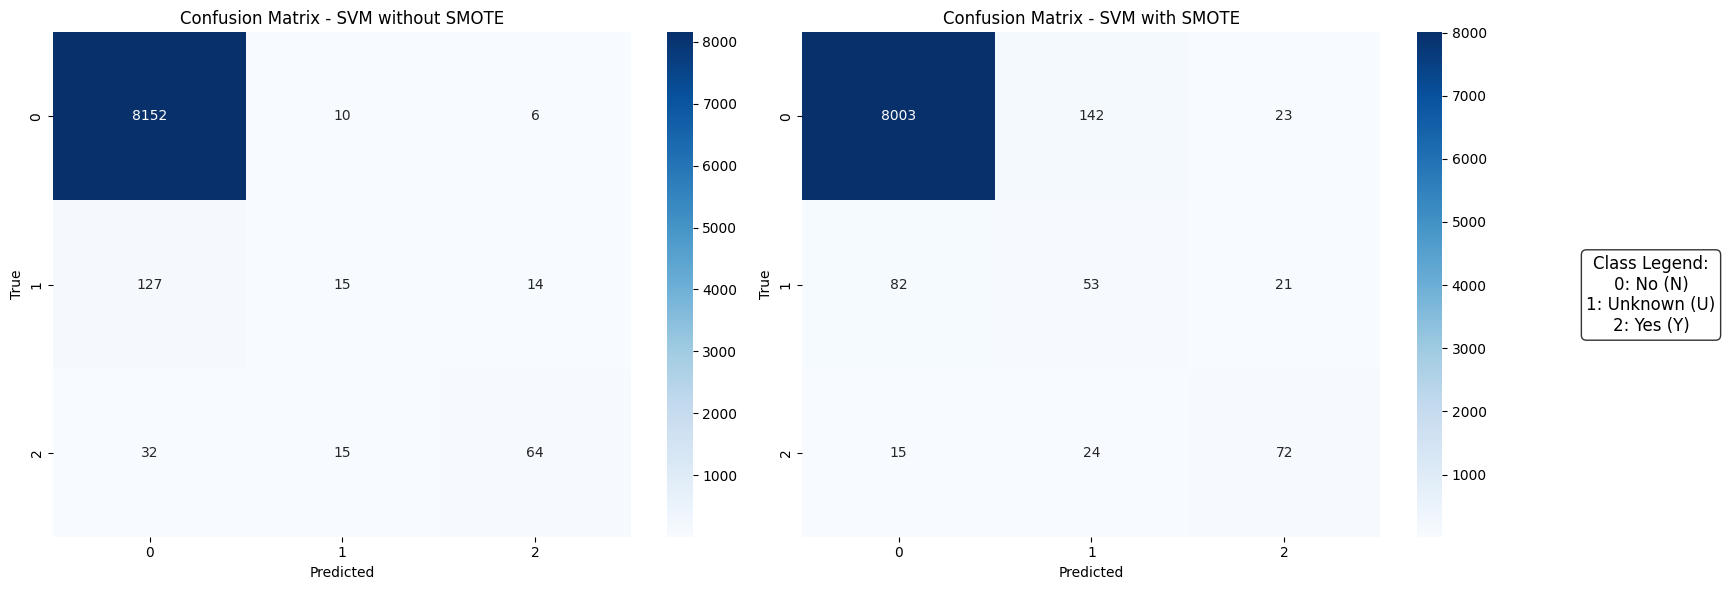

In [ ]:
# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Without SMOTE confusion matrix
sns.heatmap(cm_no_smote, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - SVM without SMOTE')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Plot With SMOTE confusion matrix
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - SVM with SMOTE')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Add a legend for the numeric labels
legend_text = "Class Legend:\n0: No (N)\n1: Unknown (U)\n2: Yes (Y)"
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
fig.text(0.92, 0.5, legend_text, ha='center', va='center', fontsize=12, bbox=props)

plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

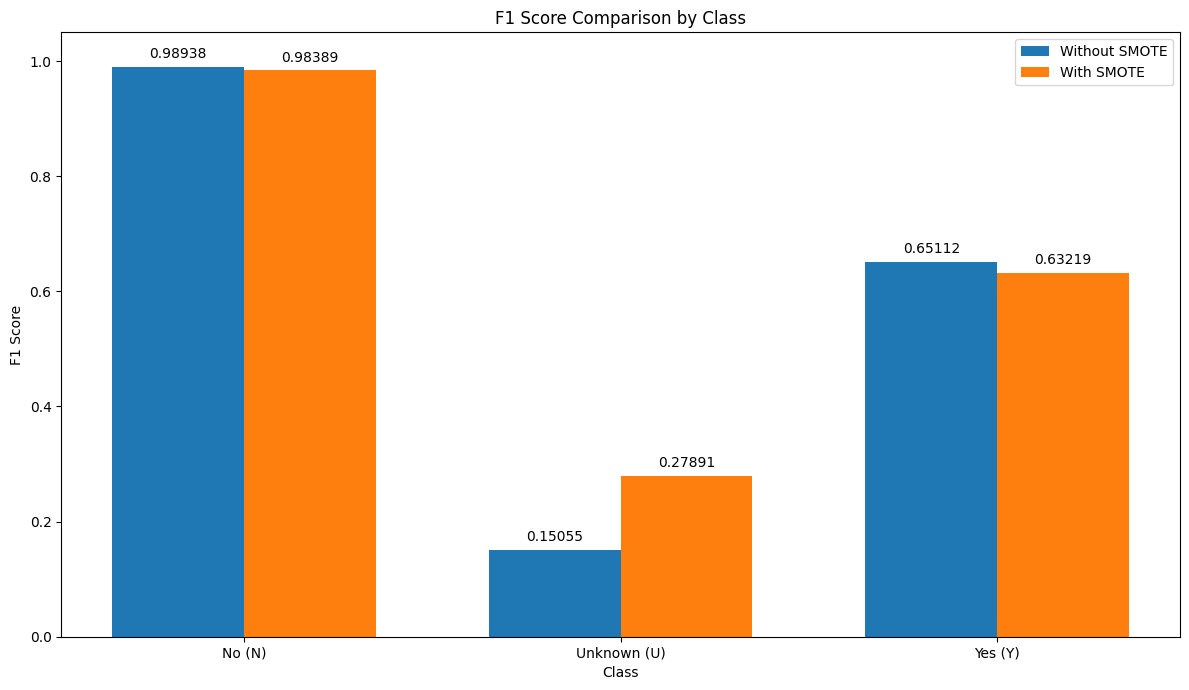

In [ ]:
# Create comparison visualisation for class-specific F1 scores
plt.figure(figsize=(12, 7))
class_labels_plot = [class_labels[c] for c in range(3)]

# Create grouped bar chart
x = np.arange(len(class_labels_plot))
width = 0.35

# Get F1 scores for each class
f1_no_smote_values = [metrics_no_smote[c]['f1'] for c in range(3)]
f1_smote_values = [metrics_smote[c]['f1'] for c in range(3)]

# Create bars
bars1 = plt.bar(x - width/2, f1_no_smote_values, width, label='Without SMOTE')
bars2 = plt.bar(x + width/2, f1_smote_values, width, label='With SMOTE')

# Add labels and values
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison by Class')
plt.xticks(x, class_labels_plot)
plt.legend()

# Add value labels
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.5f}', ha='center', va='bottom', rotation=0)

add_value_labels(bars1)
add_value_labels(bars2)

plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

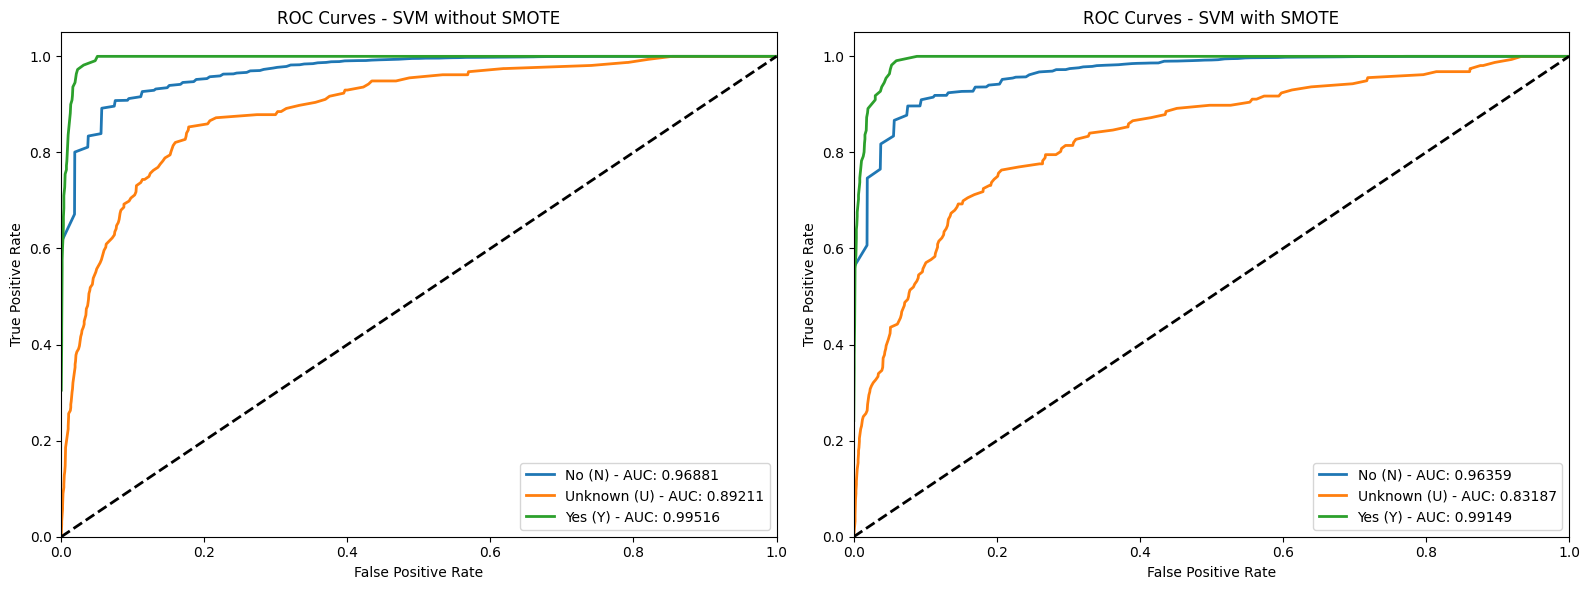

In [ ]:
# Plot ROC curves side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot ROC curves for Without SMOTE
for c in range(3):
    if not roc_data_no_smote[c]['auc']:
        continue

    # Interpolate ROC curves for averaging
    all_fpr = np.unique(np.concatenate([fpr for fpr in roc_data_no_smote[c]['fpr']]))
    mean_tpr = np.zeros_like(all_fpr)

    for fpr, tpr in zip(roc_data_no_smote[c]['fpr'], roc_data_no_smote[c]['tpr']):
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    mean_tpr /= len(roc_data_no_smote[c]['fpr'])
    mean_auc = np.mean(roc_data_no_smote[c]['auc'])

    axes[0].plot(all_fpr, mean_tpr, lw=2,
             label=f'{class_labels[c]} - AUC: {mean_auc:.5f}')

axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves - SVM without SMOTE')
axes[0].legend(loc="lower right")

# Plot ROC curves for With SMOTE
for c in range(3):
    if not roc_data_smote[c]['auc']:
        continue

    # Interpolate ROC curves for averaging
    all_fpr = np.unique(np.concatenate([fpr for fpr in roc_data_smote[c]['fpr']]))
    mean_tpr = np.zeros_like(all_fpr)

    for fpr, tpr in zip(roc_data_smote[c]['fpr'], roc_data_smote[c]['tpr']):
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    mean_tpr /= len(roc_data_smote[c]['fpr'])
    mean_auc = np.mean(roc_data_smote[c]['auc'])

    axes[1].plot(all_fpr, mean_tpr, lw=2,
             label=f'{class_labels[c]} - AUC: {mean_auc:.5f}')

axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves - SVM with SMOTE')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()